In [5]:
import keypoint_moseq as kpms
import numpy as np
from jax_moseq.utils import set_mixed_map_iters

In [6]:
MODE = "dannce"   # "dannce" or "sleap"
PROJECT_DIR = "/mnt/d/Project/Keypoint-Moseq/"
KEYPOINT_DATA = "/mnt/d/Project/Keypoint-Moseq/"

Loading keypoints: 100%|██████████████████| 4/4 [00:00<00:00, 25.08it/s]


Fitting model with kappa=10000.0
Outputs will be saved to /mnt/d/Project/Keypoint-
Moseq/my_kappa_scan-10000.0


 49%|█████████████████▏                 | 25/51 [00:21<00:22,  1.14it/s]

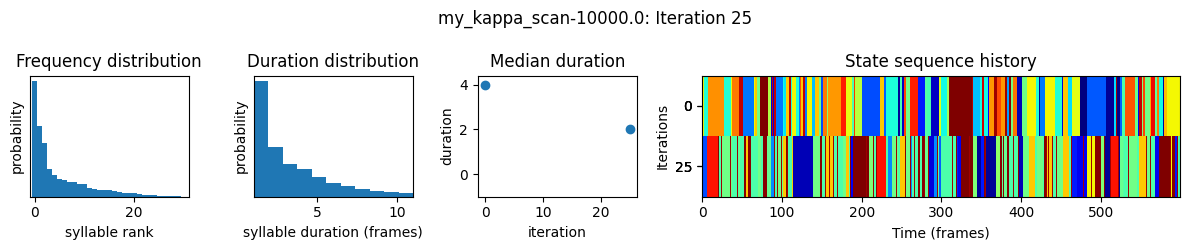

 98%|██████████████████████████████████▎| 50/51 [00:42<00:00,  1.17it/s]

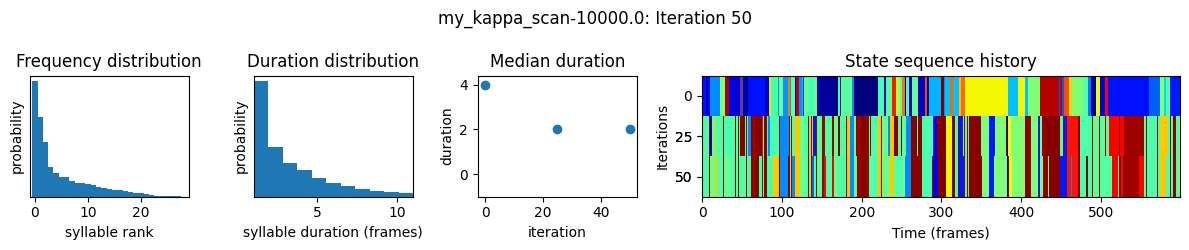

100%|███████████████████████████████████| 51/51 [00:43<00:00,  1.18it/s]


Outputs will be saved to /mnt/d/Project/Keypoint-
Moseq/my_kappa_scan-10000.0


 17%|█████▋                            | 25/151 [02:08<10:54,  5.20s/it]

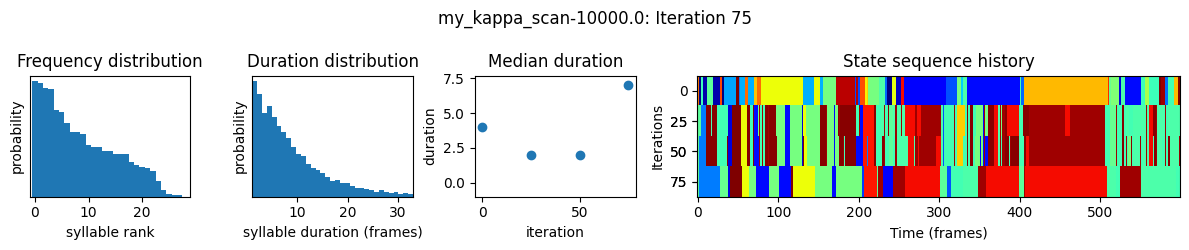

 33%|███████████▎                      | 50/151 [04:45<11:17,  6.71s/it]

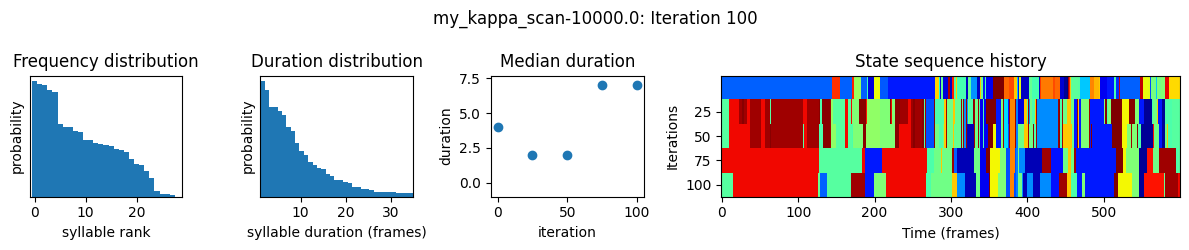

 50%|████████████████▉                 | 75/151 [06:52<06:33,  5.17s/it]

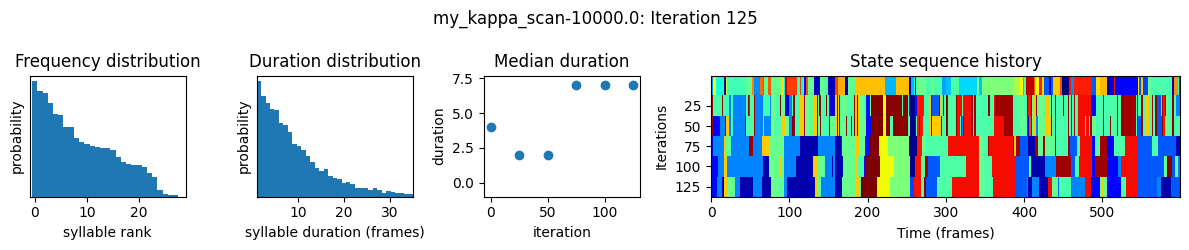

 66%|█████████████████████▊           | 100/151 [08:58<04:01,  4.74s/it]

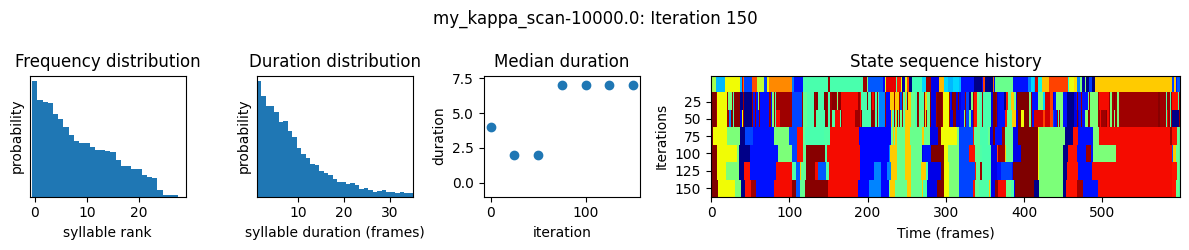

 83%|███████████████████████████▎     | 125/151 [11:12<02:43,  6.31s/it]

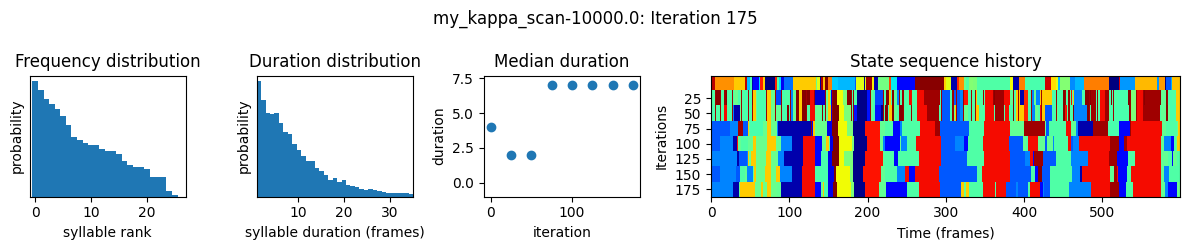

 99%|████████████████████████████████▊| 150/151 [13:27<00:05,  5.42s/it]

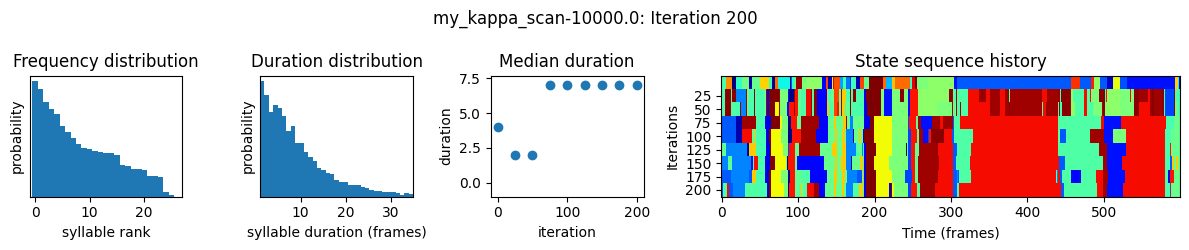

100%|█████████████████████████████████| 151/151 [13:31<00:00,  5.38s/it]


Fitting model with kappa=1000000.0
Outputs will be saved to /mnt/d/Project/Keypoint-
Moseq/my_kappa_scan-1000000.0


 49%|█████████████████▏                 | 25/51 [00:24<00:24,  1.07it/s]

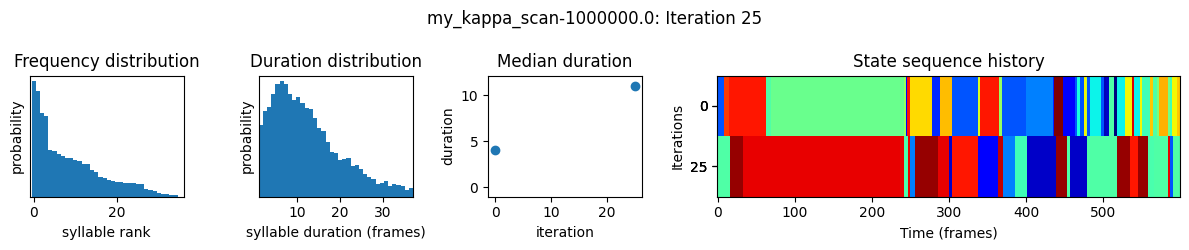

 98%|██████████████████████████████████▎| 50/51 [00:51<00:01,  1.56s/it]

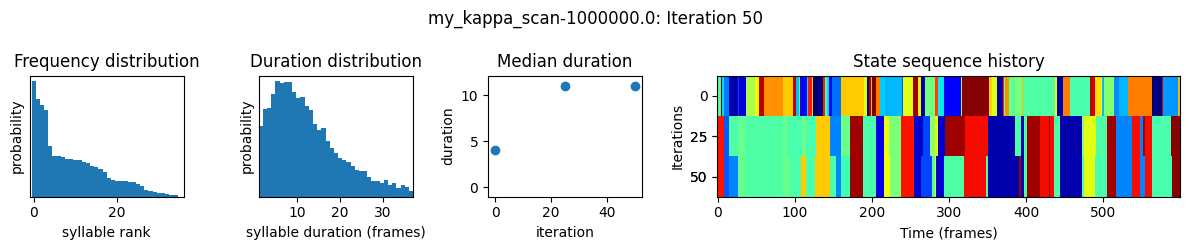

100%|███████████████████████████████████| 51/51 [00:53<00:00,  1.05s/it]


Outputs will be saved to /mnt/d/Project/Keypoint-
Moseq/my_kappa_scan-1000000.0


 17%|█████▋                            | 25/151 [02:41<12:55,  6.16s/it]

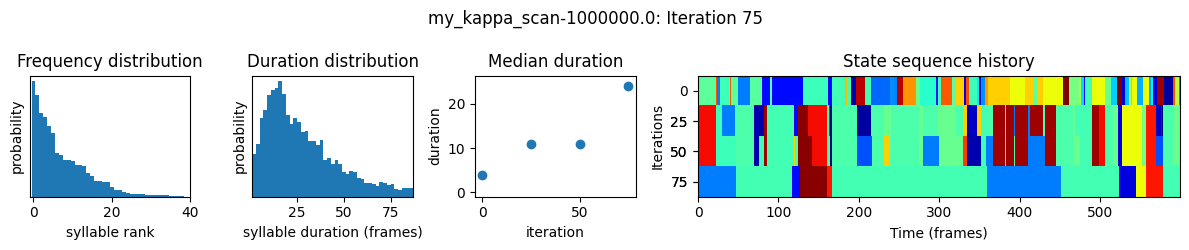

 33%|███████████▎                      | 50/151 [05:23<10:36,  6.30s/it]

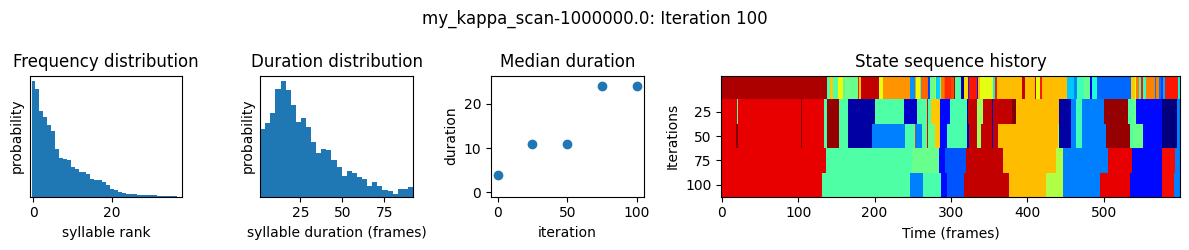

 50%|████████████████▉                 | 75/151 [07:54<07:38,  6.03s/it]

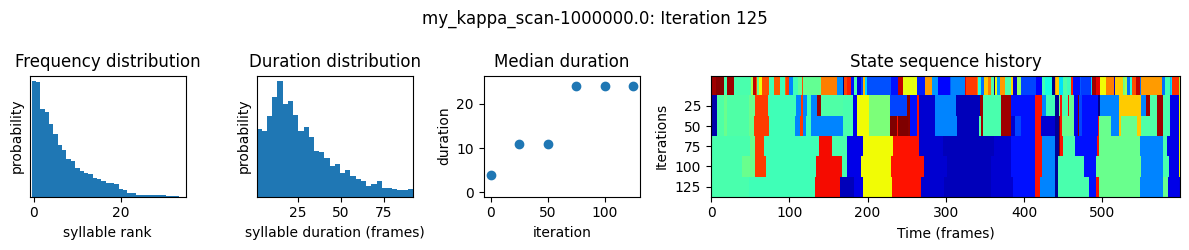

 66%|█████████████████████▊           | 100/151 [10:37<05:48,  6.83s/it]

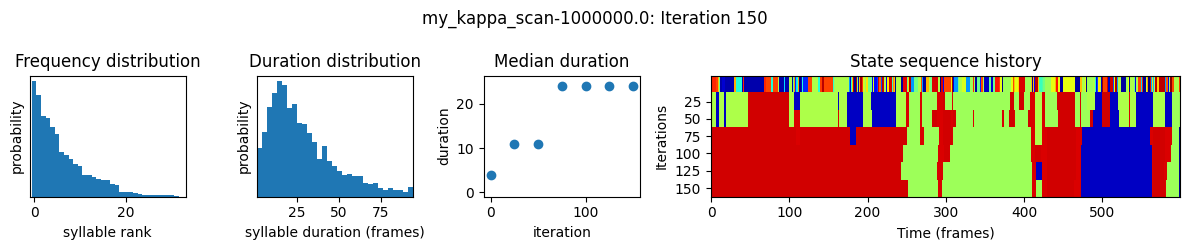

 83%|███████████████████████████▎     | 125/151 [13:15<02:40,  6.16s/it]

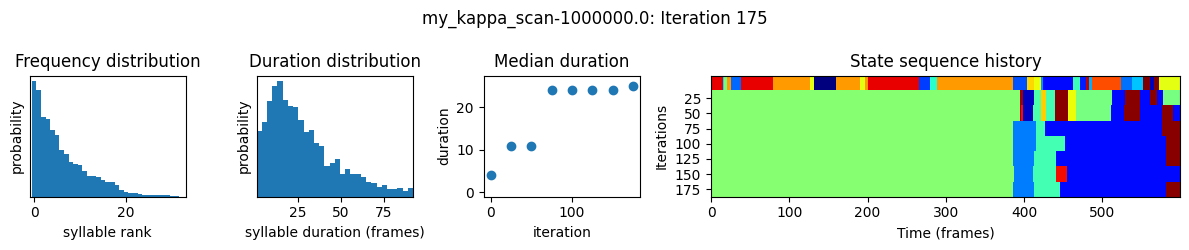

 99%|████████████████████████████████▊| 150/151 [15:41<00:05,  5.93s/it]

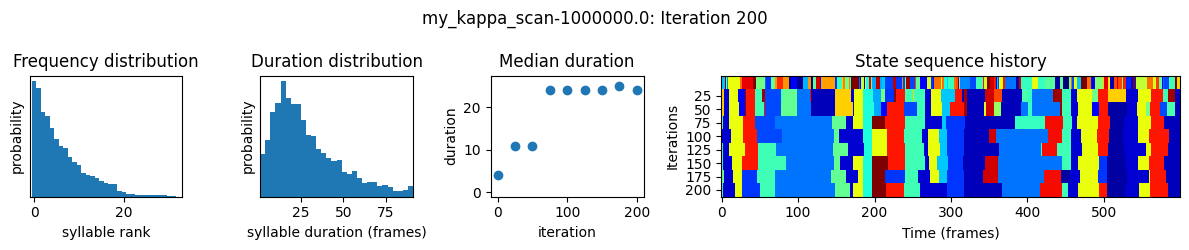

100%|█████████████████████████████████| 151/151 [15:48<00:00,  6.28s/it]


Fitting model with kappa=100000000.0
Outputs will be saved to /mnt/d/Project/Keypoint-
Moseq/my_kappa_scan-100000000.0


 49%|█████████████████▏                 | 25/51 [00:49<00:55,  2.15s/it]

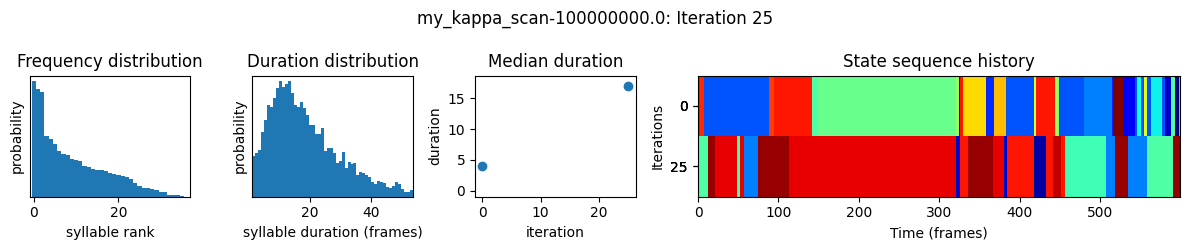

 98%|██████████████████████████████████▎| 50/51 [01:37<00:01,  1.69s/it]

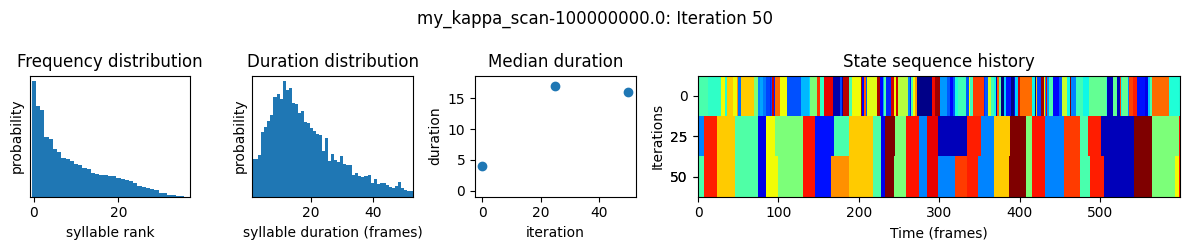

100%|███████████████████████████████████| 51/51 [01:39<00:00,  1.96s/it]


Outputs will be saved to /mnt/d/Project/Keypoint-
Moseq/my_kappa_scan-100000000.0


 17%|█████▋                            | 25/151 [02:28<12:39,  6.03s/it]

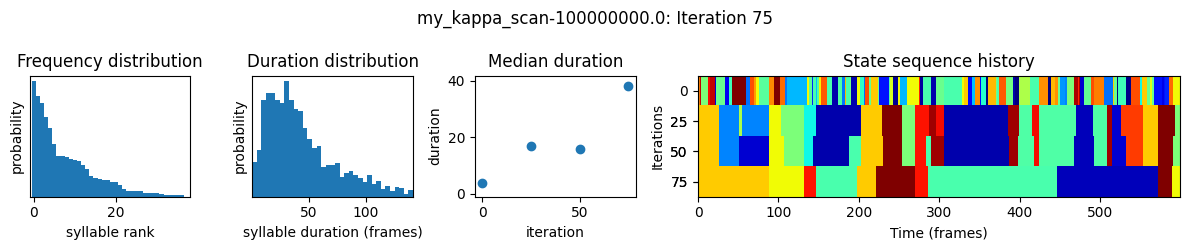

 33%|███████████▎                      | 50/151 [04:57<10:36,  6.30s/it]

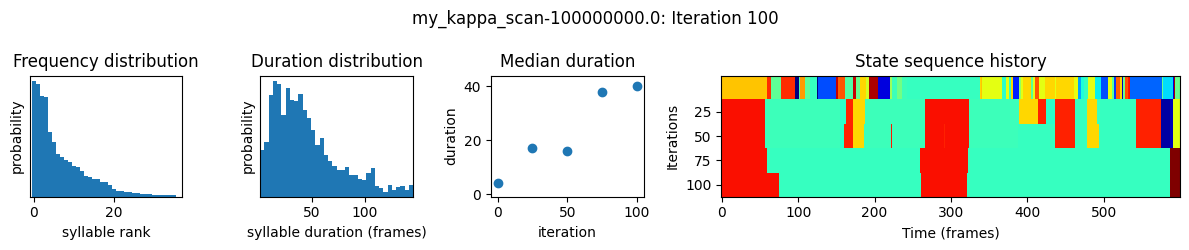

 50%|████████████████▉                 | 75/151 [07:31<08:06,  6.40s/it]

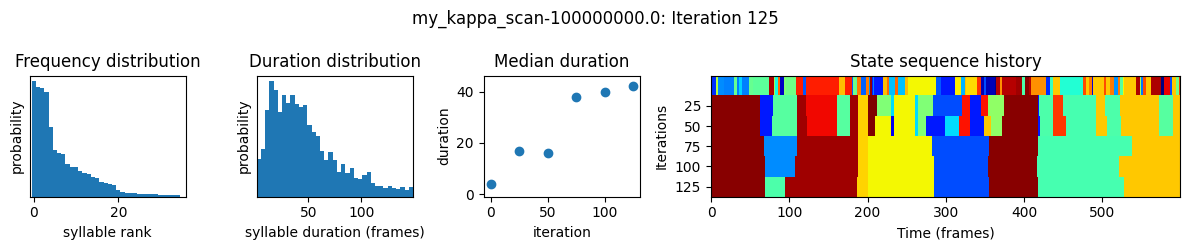

 66%|█████████████████████▊           | 100/151 [09:59<05:02,  5.93s/it]

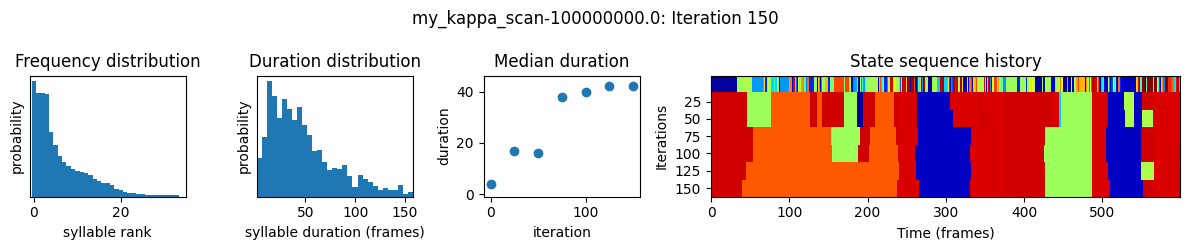

 83%|███████████████████████████▎     | 125/151 [12:31<02:37,  6.07s/it]

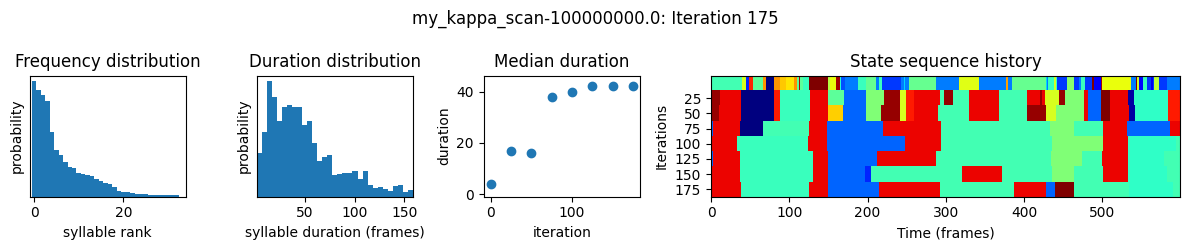

 99%|████████████████████████████████▊| 150/151 [15:00<00:05,  5.96s/it]

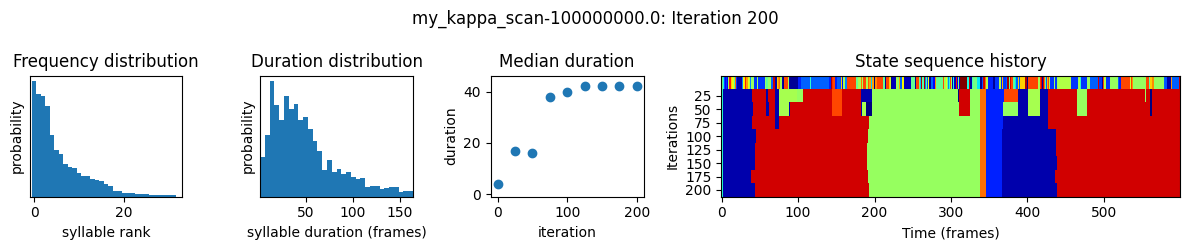

100%|█████████████████████████████████| 151/151 [15:05<00:00,  6.00s/it]


Fitting model with kappa=10000000000.0
Outputs will be saved to /mnt/d/Project/Keypoint-
Moseq/my_kappa_scan-10000000000.0


 49%|█████████████████▏                 | 25/51 [00:48<00:56,  2.16s/it]

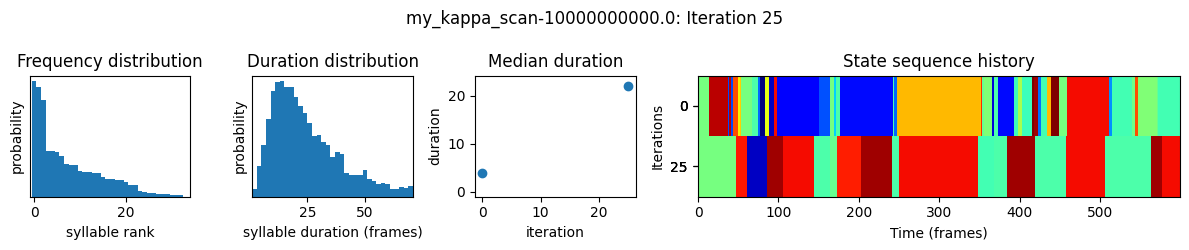

 98%|██████████████████████████████████▎| 50/51 [01:36<00:01,  1.92s/it]

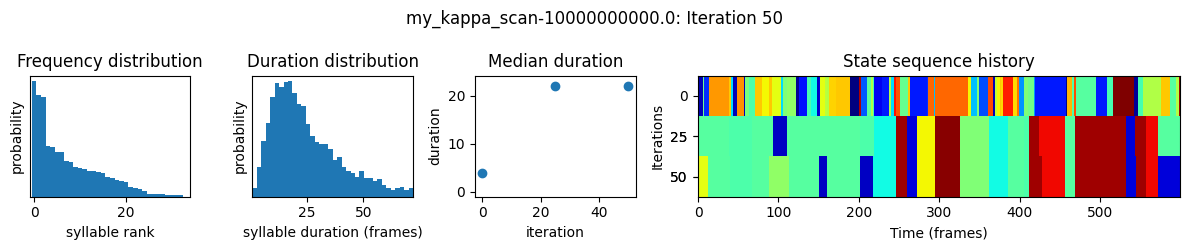

100%|███████████████████████████████████| 51/51 [01:39<00:00,  1.95s/it]


Outputs will be saved to /mnt/d/Project/Keypoint-
Moseq/my_kappa_scan-10000000000.0


 17%|█████▋                            | 25/151 [02:32<12:35,  5.99s/it]

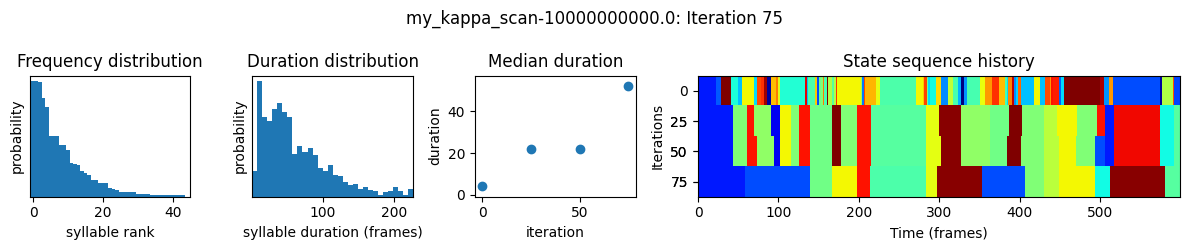

 33%|███████████▎                      | 50/151 [05:01<09:35,  5.70s/it]

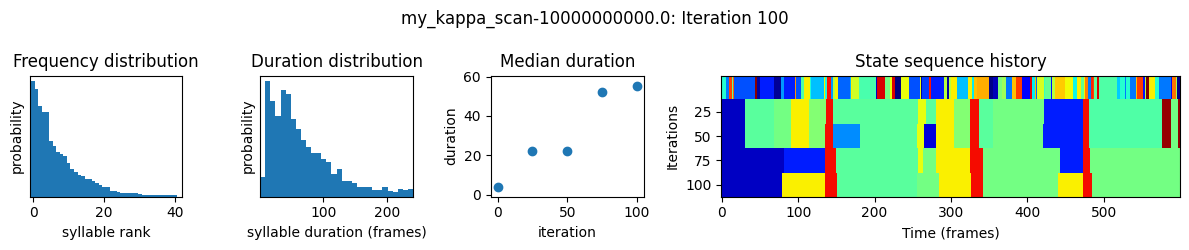

 50%|████████████████▉                 | 75/151 [07:33<07:44,  6.11s/it]

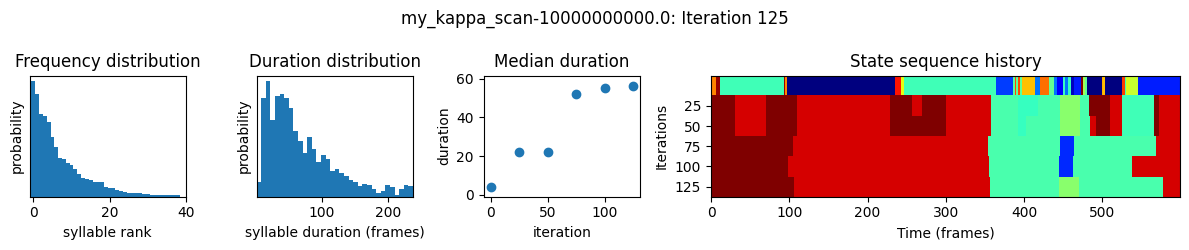

 66%|█████████████████████▊           | 100/151 [10:02<05:00,  5.90s/it]

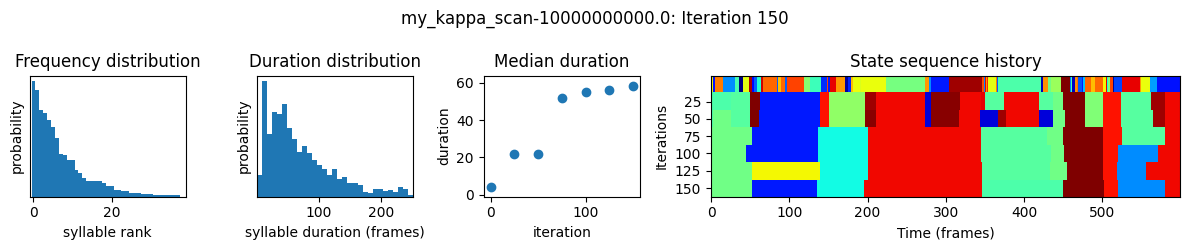

 83%|███████████████████████████▎     | 125/151 [12:32<02:34,  5.95s/it]

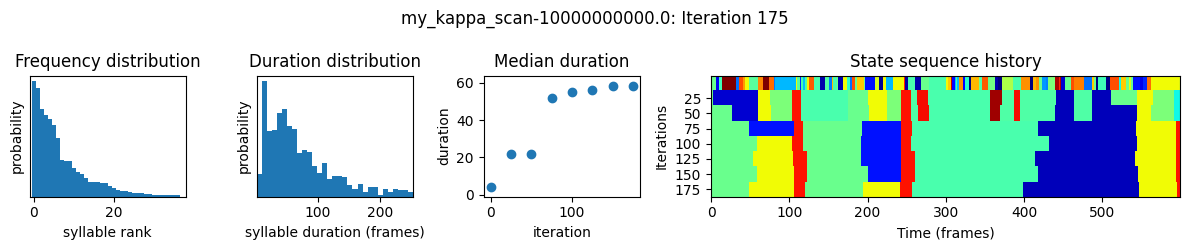

 99%|████████████████████████████████▊| 150/151 [15:01<00:05,  5.80s/it]

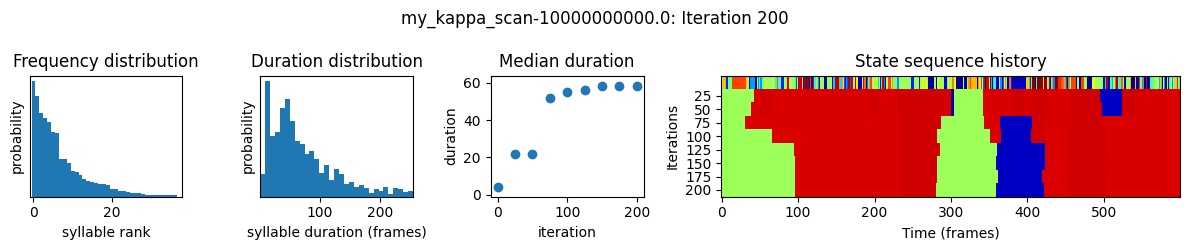

Loading checkpoints: 100%|██████████| 4/4 [00:00<00:00, 22.18it/s]


(<Figure size 800x250 with 2 Axes>, array([ 7., 24., 42., 58.]))

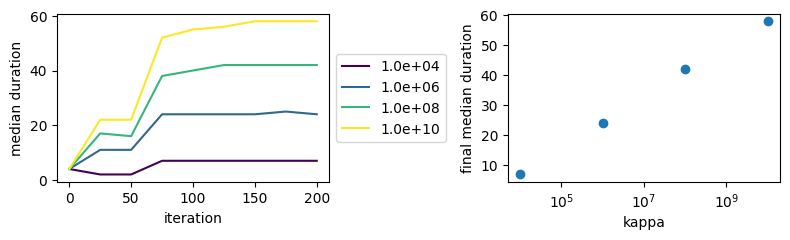

In [7]:
config = lambda: kpms.load_config(project_dir=PROJECT_DIR)
coordinates, confidences, bodyparts = kpms.load_keypoints(filepath_pattern=KEYPOINT_DATA, format=MODE)

# format data for modeling
data, metadata = kpms.format_data(coordinates, confidences, **config())
pca = kpms.load_pca(project_dir=PROJECT_DIR)

set_mixed_map_iters(4)

kappas = np.logspace(4, 10, 4)
decrease_kappa_factor = 10
num_ar_iters = 50
num_full_iters = 200

prefix = 'my_kappa_scan'

for kappa in kappas:
    print(f"Fitting model with kappa={kappa}")
    model_name = f'{prefix}-{kappa}'
    model = kpms.init_model(data, pca=pca, **config())

    # stage 1: fit the model with AR only
    model = kpms.update_hypparams(model, kappa=kappa)
    model = kpms.fit_model(
        model,
        data,
        metadata,
        PROJECT_DIR,
        model_name,
        ar_only=True,
        num_iters=num_ar_iters,
        save_every_n_iters=25
    )[0]

    # stage 2: fit the full model
    model = kpms.update_hypparams(model, kappa=kappa/decrease_kappa_factor)
    kpms.fit_model(
        model,
        data,
        metadata,
        PROJECT_DIR,
        model_name,
        ar_only=False,
        start_iter=num_ar_iters,
        num_iters=num_full_iters,
        save_every_n_iters=25
    )

kpms.plot_kappa_scan(kappas, PROJECT_DIR, prefix)